# Types of Classification
Before we continue, let’s review several different types of classification.
## Binary Classification
The simplest example of classification is binary classification, where there are only two labels
you can predict. One example is fraud analytics, where a given transaction can be classified as
fraudulent or not; or email spam, where a given email can be classified as spam or not spam.
## Multiclass Classification
Beyond binary classification lies multiclass classification, where one label is chosen from more
than two distinct possible labels. A typical example is Facebook predicting the people in a given
photo or a meterologist predicting the weather (rainy, sunny, cloudy, etc.). Note how there is
always a finite set of classes to predict; it’s never unbounded. This is also called multinomial
classification.
## Multilabel Classification
Finally, there is multilabel classification, where a given input can produce multiple labels. For
example, you might want to predict a book’s genre based on the text of the book itself. While
this could be multiclass, it’s probably better suited for multilabel because a book may fall into
multiple genres. Another example of multilabel classification is identifying the number of objects
that appear in an image. Note that in this example, the number of output predictions is not
necessarily fixed, and could vary from image to image.

# Model Scalability
Model scalability is an important consideration when choosing your model. In general, Spark has
great support for training large-scale machine learning models (note, these are large scale; on
single-node workloads there are a number of other tools that also perform well). Table 26-1 is a
simple model scalability scorecard to use to find the best model for your particular task (if
scalability is your core consideration). The actual scalability will depend on your configuration,
machine size, and other specifics but should make for a good heuristic.
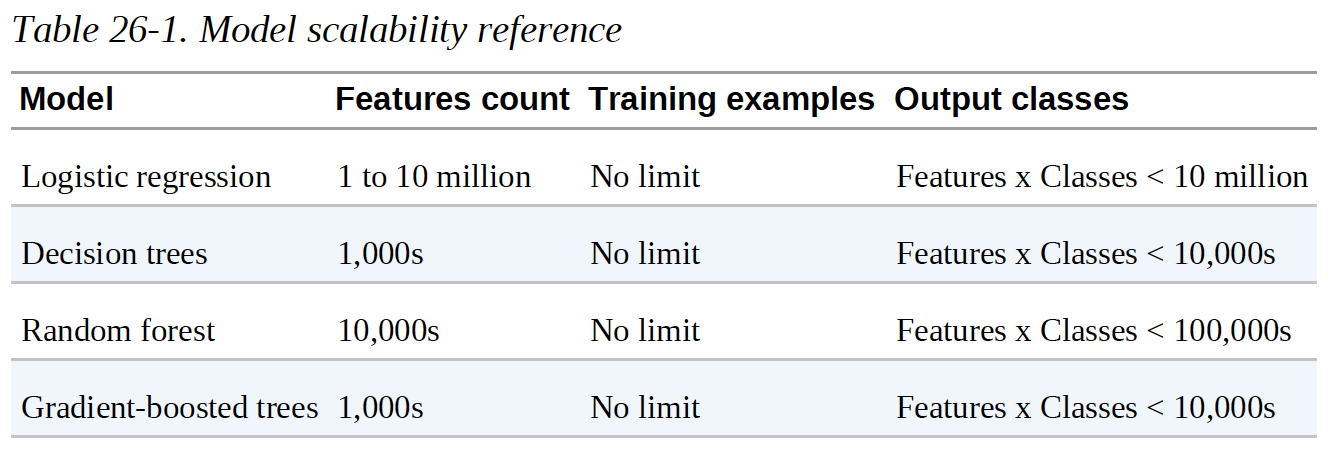

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [5]:
bInput = spark.read.format("parquet").load("../data/binary-classification")\
.selectExpr("features", "cast(label as double) as label")

## Logistic Regression
Logistic regression is one of the most popular methods of classification. It is a linear method that
combines each of the individual inputs (or features) with specific weights (these weights are
generated during the training process) that are then combined to get a probability of belonging to
a particular class. These weights are helpful because they are good representations of feature
importance; if you have a large weight, you can assume that variations in that feature have a
significant effect on the outcome (assuming you performed normalization). A smaller weight
means the feature is less likely to be important.

Here’s a simple example using the LogisticRegression model. Notice how we didn’t specify any
parameters because we’ll leverage the defaults and our data conforms to the proper column
naming. In practice, you probably won’t need to change many of the parameters:

In [7]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
print(lr.explainParams()) # see all parameters
lrModel = lr.fit(bInput)

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

Once the model is trained you can get information about the model by taking a look at the
coefficients and the intercept. The coefficients correspond to the individual feature weights (each
feature weight is multiplied by each respective feature to compute the prediction) while the
intercept is the value of the italics-intercept (if we chose to fit one when specifying the model).
Seeing the coefficients can be helpful for inspecting the model that you built and comparing how
features affect the prediction:

In [8]:
print(lrModel.coefficients)
print(lrModel.intercept)

[6.848741326854929,0.3535658901019745,14.814900276915923]
-10.22569586448109


### Model Summary
Logistic regression provides a model summary that gives you information about the final, trained
model. This is analogous to the same types of summaries we see in many R language machine
learning packages. The model summary is currently only available for binary logistic regression
problems, but multiclass summaries will likely be added in the future. Using the binary
summary, we can get all sorts of information about the model itself including the area under the
ROC curve, the f measure by threshold, the precision, the recall, the recall by thresholds, and the
ROC curve. Note that for the area under the curve, instance weighting is not taken into account,
so if you wanted to see how you performed on the values you weighed more highly, you’d have
to do that manually. This will probably change in future Spark versions. You can see the
summary using the following APIs:

In [9]:
summary = lrModel.summary
print(summary.areaUnderROC)
summary.roc.show()
summary.pr.show()

1.0
+---+------------------+
|FPR|               TPR|
+---+------------------+
|0.0|               0.0|
|0.0|0.3333333333333333|
|0.0|               1.0|
|1.0|               1.0|
|1.0|               1.0|
+---+------------------+

+------------------+---------+
|            recall|precision|
+------------------+---------+
|               0.0|      1.0|
|0.3333333333333333|      1.0|
|               1.0|      1.0|
|               1.0|      0.6|
+------------------+---------+



The speed at which the model descends to the final result is shown in the objective history. We
can access this through the objective history on the model summary:

In [10]:
summary.objectiveHistory

[0.6730116670092563,
 0.5042829330409727,
 0.36356862066874396,
 0.1252407018038337,
 0.08532556611276214,
 0.035504876415730455,
 0.018196494508571255,
 0.008817369922959136,
 0.004413673785392143,
 0.002194038351234709,
 0.0010965641148080857,
 0.000547657551985314,
 0.00027376237951490126,
 0.0001368465223657475,
 6.841809037070595e-05,
 3.420707791038497e-05,
 1.7103176664232043e-05,
 8.551470106426904e-06,
 4.275703677941461e-06,
 2.1378240117781303e-06,
 1.068856405465203e-06,
 5.34260020257524e-07,
 2.668135105897439e-07,
 1.3204627865316843e-07,
 6.768401481686428e-08,
 3.314547718487037e-08,
 1.6151438837494788e-08,
 8.309350118269286e-09]

This is an array of doubles that specify how, over each training iteration, we are performing with
respect to our objective function. This information is helpful to see if we have sufficient
iterations or need to be tuning other parameters.

# Decision Trees
Decision trees are one of the more friendly and interpretable models for performing classification
because they’re similar to simple decision models that humans use quite often. For example, if
you have to predict whether or not someone will eat ice cream when offered, a good feature
might be whether or not that individual likes ice cream. In pseudocode, if
person.likes(“ice_cream”), they will eat ice cream; otherwise, they won’t eat ice cream. A
decision tree creates this type of structure with all the inputs and follows a set of branches when
it comes time to make a prediction.

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
print(dt.explainParams())
dtModel = dt.fit(bInput)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

# Random Forest and Gradient-Boosted Trees
These methods are extensions of the decision tree. Rather than training one tree on all of the data,
you train multiple trees on varying subsets of the data. The intuition behind doing this is that
various decision trees will become “experts” in that particular domain while others become
experts in others. By combining these various experts, you then get a “wisdom of the crowds”
effect, where the group’s performance exceeds any individual. In addition, these methods can
help prevent overfitting.

In [15]:
# in Python
from pyspark.ml.classification import RandomForestClassifier
rfClassifier = RandomForestClassifier()
print(rfClassifier.explainParams())
trainedModel = rfClassifier.fit(bInput)
# in Python
from pyspark.ml.classification import GBTClassifier
gbtClassifier = GBTClassifier()
print(gbtClassifier.explainParams())
trainedModel = gbtClassifier.fit(bInput)

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

# Evaluators for Classification and Automating Model Tuning
As we saw in Chapter 24, evaluators allow us to specify the metric of success for our model. An
evaluator doesn’t help too much when it stands alone; however, when we use it in a pipeline, we
can automate a grid search of our various parameters of the models and transformers—trying all
combinations of the parameters to see which ones perform the best. Evaluators are most useful in
this pipeline and parameter grid context. For classification, there are two evaluators, and they
expect two columns: a predicted label from the model and a true label. For binary classification
we use the BinaryClassificationEvaluator. This supports optimizing for two different
metrics “areaUnderROC” and areaUnderPR.” For multiclass classification, we need to use the
MulticlassClassificationEvaluator, which supports optimizing for “f1”,
“weightedPrecision”, “weightedRecall”, and “accuracy”.
To use evaluators, we build up our pipeline, specify the parameters we would like to test, and
then run it and see the results. See Chapter 24 for a code example.

There are three different classification metrics we can use:
1. Binary classification metrics
2. Multiclass classification metrics
3. Multilabel classification metrics

All of these measures follow the same approximate style. We’ll compare generated outputs with
true values and the model calculates all of the relevant metrics for us. Then we can query the
object for the values for each of the metrics:

In [17]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
out = trainedModel.transform(bInput)\
.select("prediction", "label")\
.rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = BinaryClassificationMetrics(out)

Once we’ve done that, we can see typical classification success metrics on this metric’s object
using a similar API to the one we saw with logistic regression:

In [18]:
print(metrics.areaUnderPR)
print(metrics.areaUnderROC)
print("Receiver Operating Characteristic")
metrics.roc.toDF().show()

1.0
1.0
Receiver Operating Characteristic


AttributeError: 'BinaryClassificationMetrics' object has no attribute 'roc'

In [19]:
sc.version

'3.0.1'

In [22]:
dir(metrics)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_java_model',
 '_sc',
 'areaUnderPR',
 'areaUnderROC',
 'call',
 'unpersist']